In [1]:
%pip install -qU sagemaker boto3

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
aiobotocore 2.11.2 requires botocore<1.34.35,>=1.33.2, but you have botocore 1.34.100 which is incompatible.
anthropic-bedrock 0.4.0 requires anyio<4,>=3.5.0, but you have anyio 4.2.0 which is incompatible.


In [59]:
import sagemaker

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()

import boto3

account_id = boto3.client("sts").get_caller_identity().get("Account")
region_name = boto3.session.Session().region_name

In [60]:
suffix = "com"
if region_name.startswith('cn'):
    suffix = "com.cn"
    
model_name = None
image_uri = "{0}.dkr.ecr.{1}.amazonaws.{2}/story-diffusion-inference-api:latest".format(
    account_id, region_name,suffix
)
base_name = sagemaker.utils.base_name_from_image(image_uri)
image_uri

'434444145045.dkr.ecr.us-east-1.amazonaws.com/story-diffusion-inference-api:latest'

In [61]:
!touch dummy
!tar czvf model.tar.gz dummy
model_data = 's3://{0}/{1}/model.tar.gz'.format(bucket, 'story-diffusion')
!aws s3 cp model.tar.gz $model_data
!rm -f dummy model.tar.gz

dummy
upload: ./model.tar.gz to s3://sagemaker-us-east-1-434444145045/story-diffusion/model.tar.gz


In [62]:
from sagemaker.model import Model
from sagemaker.predictor import Predictor

model = Model(
    name=model_name,
    model_data=model_data,
    role=role,
    image_uri=image_uri,
    predictor_cls=Predictor,
)

In [63]:
instance_type = "ml.g5.4xlarge"
instance_count = 1

In [64]:
predictor = model.deploy(
    instance_type=instance_type,
    initial_instance_count=instance_count,
    container_startup_health_check_timeout=1200,
)

-------------!

In [65]:
print(predictor.endpoint_name)

story-diffusion-inference-api-2024-05-08-15-22-31-389


In [66]:
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

predictor.serializer = JSONSerializer()
predictor.deserializer = JSONDeserializer()

inputs = {
  "general_prompt": "a boy",
  "negative_prompt": "naked, deformed, bad anatomy, disfigured, poorly drawn face, mutation, extra limb, ugly, disgusting, poorly drawn hands, missing limb, floating limbs, disconnected limbs, blurry, watermarks, oversaturated, distorted hands, amputation",
  "prompt_array": "Zane's peaceful village life is disrupted when he and his friend Mara venture into the nearby woods, leading to an unexpected turn of events.\nZane and his friend discover an ancient, weathered book hidden in the forest.",
   "style": "Japanese Anime",
    "G_height":512,
    "G_width":768,
}


In [67]:

prediction = predictor.predict(inputs)

In [68]:
from io import BytesIO
import base64
from PIL import Image

def base64_to_image(base64_string):
    """
    Converts a base64 string to a PIL.Image.Image object.
    
    Args:
        base64_string (str): The base64 string representation of the image.
        
    Returns:
        PIL.Image.Image: The image object.
    """
    image_bytes = base64.b64decode(base64_string)
    image_buffer = BytesIO(image_bytes)
    image = Image.open(image_buffer)
    return image

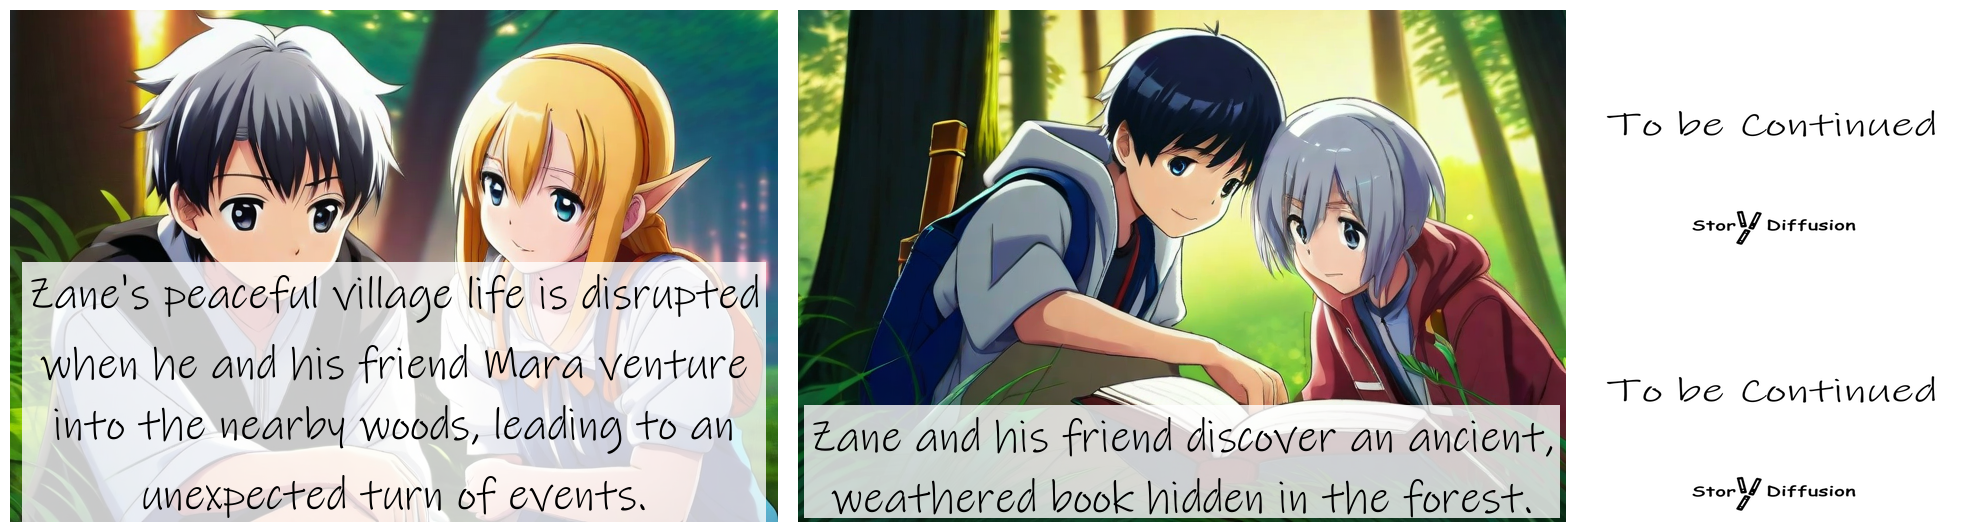

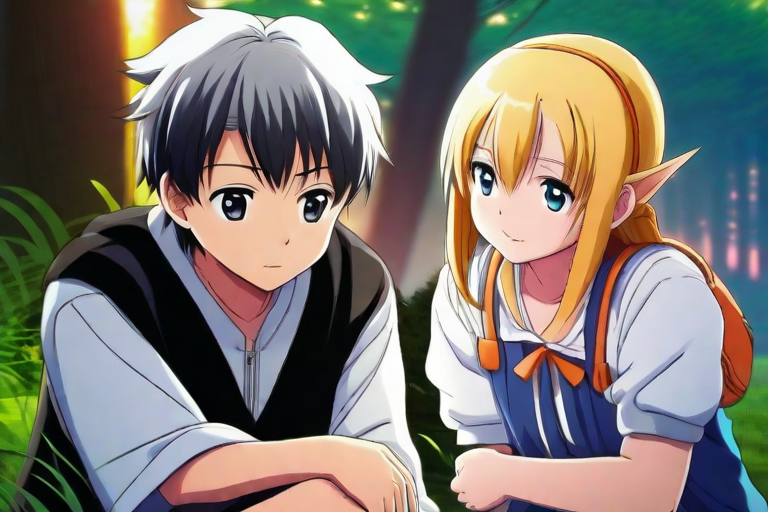

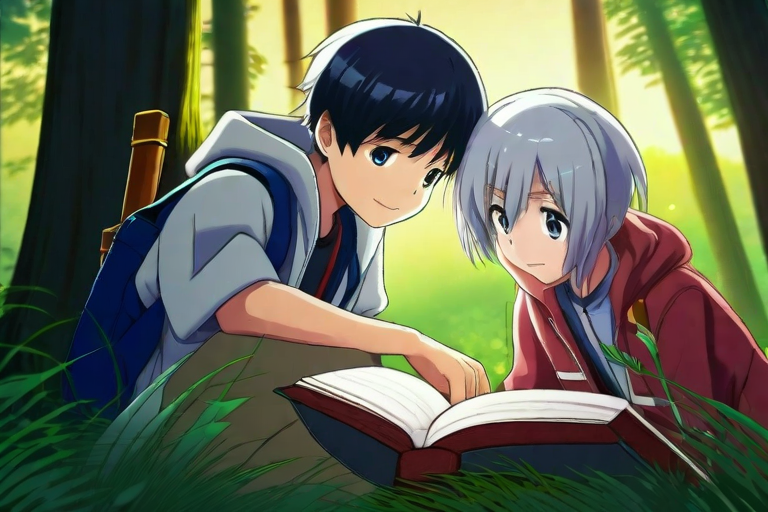

In [69]:
for img in prediction['images_base64']:
    base64_to_image(img).show()

In [70]:
import json
import boto3
from boto3.session import Config

smr_client = boto3.client("sagemaker-runtime", config=Config(
    connect_timeout=10,  # Connection timeout in seconds
    read_timeout=300, ))
endpoint_name = predictor.endpoint_name

In [71]:
response_model = smr_client.invoke_endpoint(
            EndpointName=endpoint_name,
            Body=json.dumps(
                inputs
            ),
            ContentType="application/json",
        )


In [72]:
resp = response_model['Body'].read()

In [73]:
respobj = json.loads(resp)

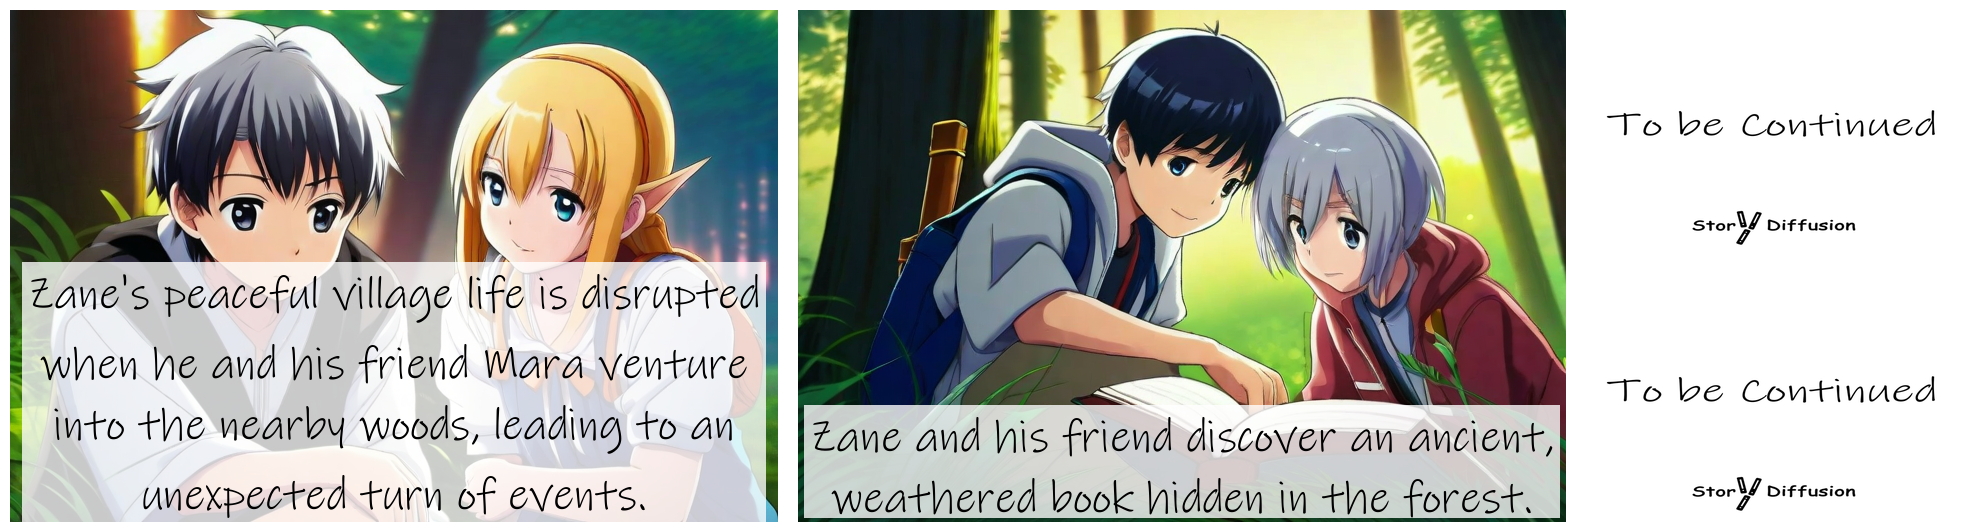

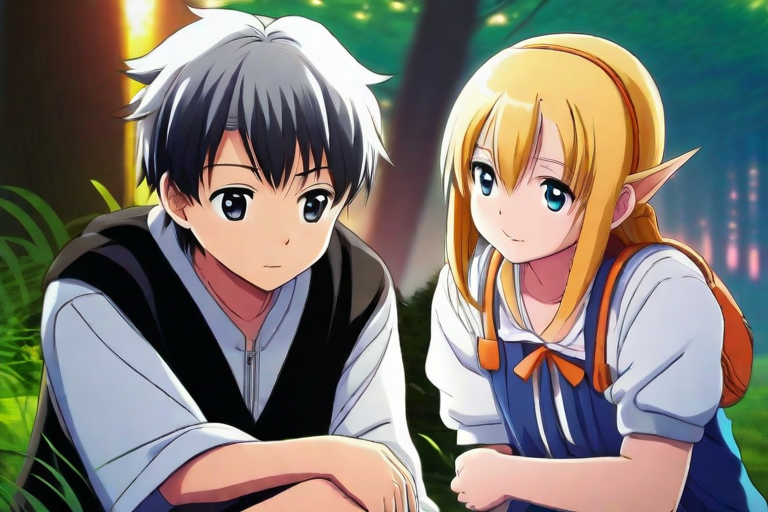

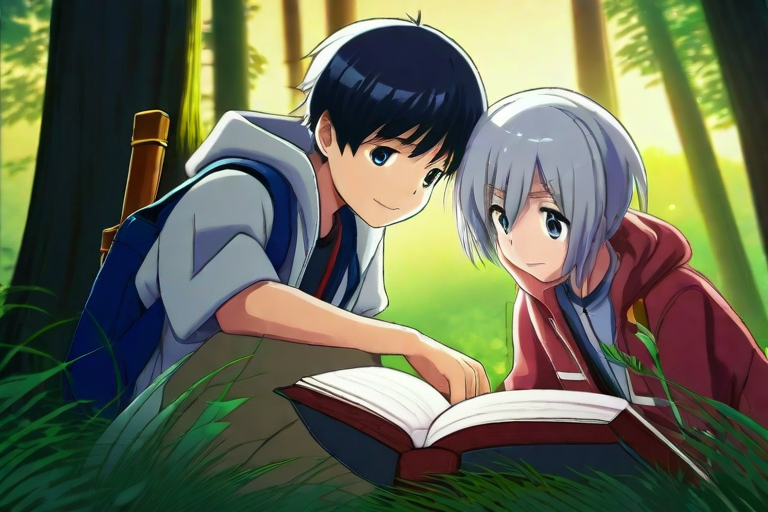

In [74]:
for img in respobj['images_base64']:
    base64_to_image(img).show()

In [75]:
from io import BytesIO
def Image2base64(img_path):
    image = Image.open(img_path)
    buffer = BytesIO()
    image.save(buffer, format="PNG")
    image_data = buffer.getvalue()
    base64_encoded_string = base64.b64encode(image_data).decode('utf-8')

    return base64_encoded_string

In [76]:
imgdata = Image2base64('./examples/taylor/1-1.png')

In [77]:
payload = json.dumps({
  "general_prompt": "women img",
  "negative_prompt": "naked, deformed, bad anatomy, disfigured, poorly drawn face, mutation, extra limb, ugly, disgusting, poorly drawn hands, missing limb, floating limbs, disconnected limbs, blurry, watermarks, oversaturated, distorted hands, amputation",
  "prompt_array": "wake up in the bed\nhave breakfast\nis on the road, go to the school",
   "style": "Comic book",
    "G_height":512,
    "G_width":768,
    "files":[imgdata]
})

In [ ]:
response_model = smr_client.invoke_endpoint(
            EndpointName=endpoint_name,
            Body=payload,
            ContentType="application/json",
        )

In [ ]:
resp = response_model['Body'].read()
respobj = json.loads(resp)

In [ ]:
for img in respobj['images_base64']:
    base64_to_image(img).show()